This tutorial will be focused on computing the maximum cross-correlation...

TODO:
- Extract parameters of best cross-correlation for in-plane translations
- Whitening filter
- Write STAR file of results
- Formalize tutorial
- Write additional test in cryojax
- Next? Further optimize with gradient descent

In [1]:
import equinox as eqx

In [2]:
# Plotting imports and function definitions
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_image(image, fig, ax, cmap="gray", label=None, **kwargs):
    im = ax.imshow(image, cmap=cmap, origin="lower", **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    if label is not None:
        ax.set(title=label)
    return fig, ax

In [3]:
import cryojax.simulator as cxs

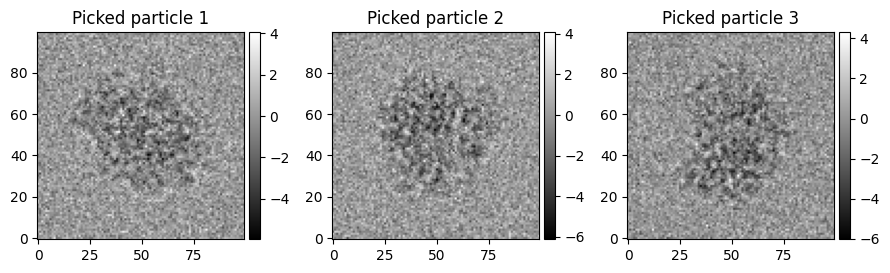

In [46]:
# Read dataset and extract normalized particle stack
import jax

from cryojax.data import RelionDataset
from cryojax.image import normalize_image, rfftn


@jax.vmap
def normalize_image_stack(image):
    return normalize_image(image, is_real=True)


make_config_fn = lambda shape, pixel_size, voltage_in_kilovolts: cxs.InstrumentConfig(
    shape, pixel_size, voltage_in_kilovolts, padded_shape=potential.shape[0:2]
)
dataset = RelionDataset(
    path_to_starfile="./data/ribosome_4ug0_particles.star",
    path_to_relion_project="./",
    make_instrument_config_fn=make_config_fn,
)

particle_stack = dataset[:3]
fourier_image_stack = rfftn(
    normalize_image_stack(particle_stack.image_stack), axes=(1, 2)
)

n_images = particle_stack.image_stack.shape[0]
fig, axes = plt.subplots(figsize=(3 * n_images, 3), ncols=n_images)
[
    plot_image(
        particle_stack.image_stack[i],
        fig,
        axes[i],
        label=f"Picked particle {i+1}",
    )
    for i in range(n_images)
]
plt.tight_layout()

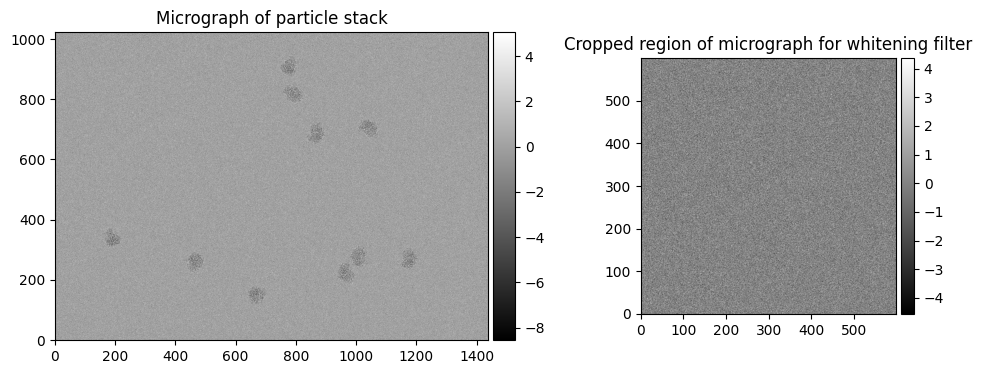

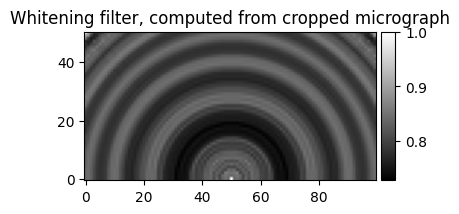

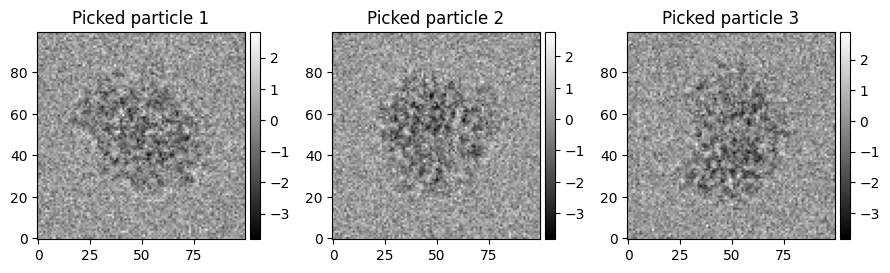

In [50]:
import pathlib
from functools import partial

import jax.numpy as jnp

from cryojax.data import read_array_from_mrc
from cryojax.image import irfftn, operators as op


path_to_micrograph = pathlib.Path(
    dataset.path_to_relion_project,
    dataset.data_blocks["particles"].iloc[0]["rlnMicrographName"],
)
micrograph = normalize_image(jnp.asarray(read_array_from_mrc(path_to_micrograph)))
cropped_micrograph = micrograph[400:1000, :600]

fig, axes = plt.subplot_mosaic(
    """
AAB
""",
    figsize=(12, 4),
)
plot_image(micrograph, fig, axes["A"], label="Micrograph of particle stack")
plot_image(
    cropped_micrograph,
    fig,
    axes["B"],
    label="Cropped region of micrograph for whitening filter",
)

fig, ax = plt.subplots(figsize=(4, 3))
shape = particle_stack.image_stack[0].shape
whitening_filter = op.WhiteningFilter(cropped_micrograph, shape=shape)
plot_image(
    jnp.fft.fftshift(whitening_filter.buffer, axes=(0,)).T,
    fig,
    ax,
    label="Whitening filter, computed from cropped micrograph",
)
plt.tight_layout()


@partial(eqx.filter_vmap, in_axes=(0, None))
def whiten_fourier_image_stack(fourier_image, whitening_filter):
    return whitening_filter(fourier_image)


whitened_fourier_image_stack = whiten_fourier_image_stack(
    fourier_image_stack, whitening_filter
)
fig, axes = plt.subplots(figsize=(3 * n_images, 3), ncols=n_images)
[
    plot_image(
        irfftn(whitened_fourier_image_stack[i]),
        fig,
        axes[i],
        label=f"Picked particle {i+1}",
    )
    for i in range(n_images)
]
plt.tight_layout()

In [5]:
from functools import partial

import equinox.internal as eqxi
import jax

from cryojax.data import read_array_with_spacing_from_mrc
from cryojax.rotations import SO3


@partial(eqx.filter_vmap, out_axes=eqxi.if_mapped(axis=0))
def make_pose_grid(key):
    return cxs.QuaternionPose.from_rotation(SO3.sample_uniform(key))


number_of_poses = 100_000
keys = jax.random.split(jax.random.PRNGKey(0), number_of_poses)
pose_grid = make_pose_grid(keys)

# Instantiate the scattering potential
filename = "./data/ribosome_4ug0_scattering_potential_from_cistem.mrc"
real_voxel_grid, voxel_size = read_array_with_spacing_from_mrc(filename)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    real_voxel_grid, voxel_size, pad_scale=1.5
)

# ... now, build the biological specimen
structural_ensemble = cxs.SingleStructureEnsemble(
    conformational_space=potential, pose=pose_grid
)

In [6]:
# Build cryojax specimen

In [7]:
# Make the instrument from the particle stack
import cryojax as cx


@partial(eqx.filter_vmap, in_axes=(0, None), out_axes=eqxi.if_mapped(axis=0))
def make_transfer_theory(vmap, no_vmap):
    ctf = eqx.combine(vmap, no_vmap)
    return cxs.ContrastTransferTheory(ctf)


ctf_filter_spec = cx.get_filter_spec(
    particle_stack.transfer_function,
    lambda x: (
        x.defocus_u_in_angstroms,
        x.defocus_v_in_angstroms,
        x.astigmatism_angle,
        x.phase_shift,
    ),
)
per_particle_ctf, optics_group_ctf = eqx.partition(
    particle_stack.transfer_function, ctf_filter_spec
)
transfer_theory = make_transfer_theory(per_particle_ctf, optics_group_ctf)

# ... now instantiate fourier slice extraction
projection_method = cxs.FourierSliceExtract(interpolation_order=1)
scattering_theory = cxs.LinearScatteringTheory(
    structural_ensemble, projection_method, transfer_theory
)

imaging_pipeline = cxs.ContrastImagingPipeline(
    particle_stack.instrument_config, scattering_theory
)

In [8]:
from cryojax.image import irfftn


per_particle_filter_spec = cx.get_filter_spec(
    imaging_pipeline,
    lambda p: (
        p.instrument.optics.ctf.defocus_u_in_angstroms,
        p.instrument.optics.ctf.defocus_v_in_angstroms,
        p.instrument.optics.ctf.astigmatism_angle,
        p.instrument.optics.ctf.phase_shift,
    ),
)


@partial(cx.filter_vmap_with_spec, filter_spec=per_particle_filter_spec, in_axes=(0, 0))
def cross_correlation(pipeline, fourier_observed_image):
    fourier_simulated_image = pipeline.render(get_real=False, normalize=True)
    return (
        irfftn(
            fourier_observed_image * jnp.conj(fourier_simulated_image),
            s=pipeline.instrument_config.shape,
        )
        / pipeline.instrument_config.n_pix
    )


@eqx.filter_jit
def objective_function(pipeline_at_grid_point, args):
    (
        pipeline_not_at_grid_point_vmap,
        pipeline_not_at_grid_point_no_vmap,
        fourier_observed_image_stack,
    ) = args
    pipeline_not_at_grid_point = eqx.combine(
        pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap
    )
    pipeline = eqx.combine(pipeline_at_grid_point, pipeline_not_at_grid_point)

    return -cross_correlation(pipeline, fourier_observed_image_stack)


@partial(eqx.filter_vmap, in_axes=(None, (0, None)))
def simulate_fourier_image_stack(pipeline_at_grid_point, args):
    pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap = args
    pipeline_not_at_grid_point = eqx.combine(
        pipeline_not_at_grid_point_vmap, pipeline_not_at_grid_point_no_vmap
    )
    pipeline = eqx.combine(pipeline_at_grid_point, pipeline_not_at_grid_point)

    return pipeline.render(get_real=False, normalize=True)

In [9]:
from cryojax.inference import tree_grid_take, tree_grid_unravel_index


tree_grid_filter_spec = cx.get_filter_spec(
    imaging_pipeline, lambda p: p.specimen.pose.wxyz
)

pipeline_tree_grid, pipeline_non_tree_grid = eqx.partition(
    imaging_pipeline, tree_grid_filter_spec
)
per_particle_pipeline, non_per_particle_pipeline = eqx.partition(
    pipeline_non_tree_grid, per_particle_filter_spec
)

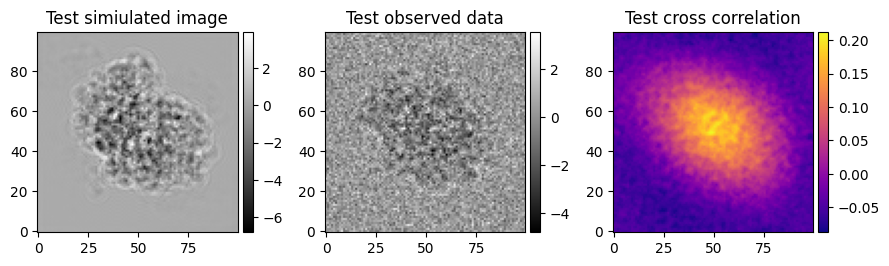

In [10]:
test_pipeline_grid_point = tree_grid_take(
    pipeline_tree_grid, tree_grid_unravel_index(0, pipeline_tree_grid)
)
test_simulated_fourier_image_stack = simulate_fourier_image_stack(
    test_pipeline_grid_point, (per_particle_pipeline, non_per_particle_pipeline)
)
neg_cc = objective_function(
    test_pipeline_grid_point,
    (per_particle_pipeline, non_per_particle_pipeline, fourier_image_stack),
)
fig, axes = plt.subplots(figsize=(9, 3.5), ncols=3)
plot_image(
    irfftn(
        test_simulated_fourier_image_stack[0],
        s=imaging_pipeline.instrument_config.shape,
    ),
    fig,
    axes[0],
    label="Test simiulated image",
)
plot_image(
    irfftn(fourier_image_stack[0], s=imaging_pipeline.instrument_config.shape),
    fig,
    axes[1],
    label="Test observed data",
)
plot_image(
    -neg_cc[0],
    fig,
    axes[2],
    label="Test cross correlation",
    cmap="plasma",
)
plt.tight_layout()

In [11]:
import math

from cryojax.inference import MinimumSearchMethod, run_grid_search, tree_grid_shape


method = MinimumSearchMethod(batch_size=100)
n_iterations = math.prod(tree_grid_shape(pipeline_tree_grid)) // method.batch_size
result = run_grid_search(
    objective_function,
    method,
    pipeline_tree_grid,
    args=(per_particle_pipeline, non_per_particle_pipeline, fourier_image_stack),
    progress_bar=True,
    print_every=n_iterations // 20,
)

/Users/michael/mambaforge/envs/cryojax/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2554: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
/Users/michael/mambaforge/envs/cryojax/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:2555: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
/Users/michael/mambaforge/envs/cryojax/lib/python3.10/site-packages/jax/_src/numpy/array_m

  0%|          | 0/1000 [00:00<?, ?it/s]

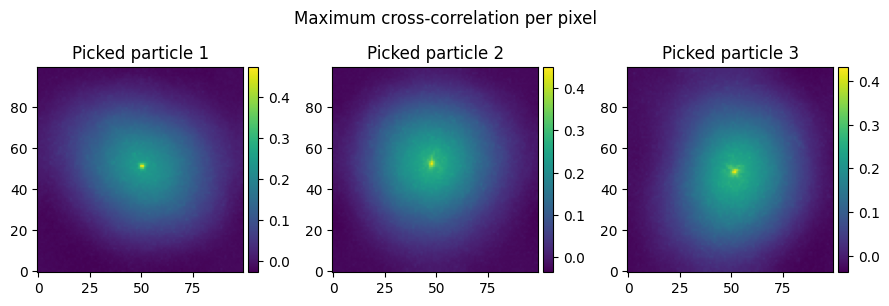

In [12]:
n_images = particle_stack.image_stack.shape[0]
fig, axes = plt.subplots(figsize=(3 * n_images, 3), ncols=n_images)
fig.suptitle("Maximum cross-correlation per pixel")
[
    plot_image(
        -result.state.current_minimum_eval[i],
        fig,
        axes[i],
        cmap="viridis",
        label=f"Picked particle {i+1}",
    )
    for i in range(n_images)
]
plt.tight_layout()

In [13]:
@partial(eqx.filter_vmap, in_axes=(0, (None, 0, None)), out_axes=eqxi.if_mapped(0))
def extract_solution_at_minimum(final_state, args):
    pipeline_grid, per_particle_pipeline, non_per_particle_pipeline = args
    image_index_at_minimum = jnp.argmin(final_state.current_minimum_eval.ravel())
    raveled_grid_index_at_minimum = final_state.current_best_raveled_index.ravel()[
        image_index_at_minimum
    ]
    tree_grid_index_at_minimum = tree_grid_unravel_index(
        raveled_grid_index_at_minimum, pipeline_grid
    )
    solution = tree_grid_take(pipeline_grid, tree_grid_index_at_minimum)
    return eqx.combine(
        solution, eqx.combine(per_particle_pipeline, non_per_particle_pipeline)
    )

In [14]:
solution_filter_spec = jax.tree_util.tree_map(
    lambda x, y: x or y, per_particle_filter_spec, tree_grid_filter_spec
)
solution_pipeline = extract_solution_at_minimum(
    result.state, (pipeline_tree_grid, per_particle_pipeline, non_per_particle_pipeline)
)


@partial(cx.filter_vmap_with_spec, filter_spec=solution_filter_spec)
def simulate_solution_image_stack(pipeline):
    return pipeline.render(normalize=True)


@partial(cx.filter_vmap_with_spec, filter_spec=solution_filter_spec, in_axes=(0, 0))
def compute_solution_cross_correlation(pipeline, fourier_observed_image):
    fourier_simulated_image = pipeline.render(get_real=False, normalize=True)
    return (
        irfftn(
            fourier_observed_image * jnp.conj(fourier_simulated_image),
            s=pipeline.instrument_config.shape,
        )
        / pipeline.instrument_config.n_pix
    )

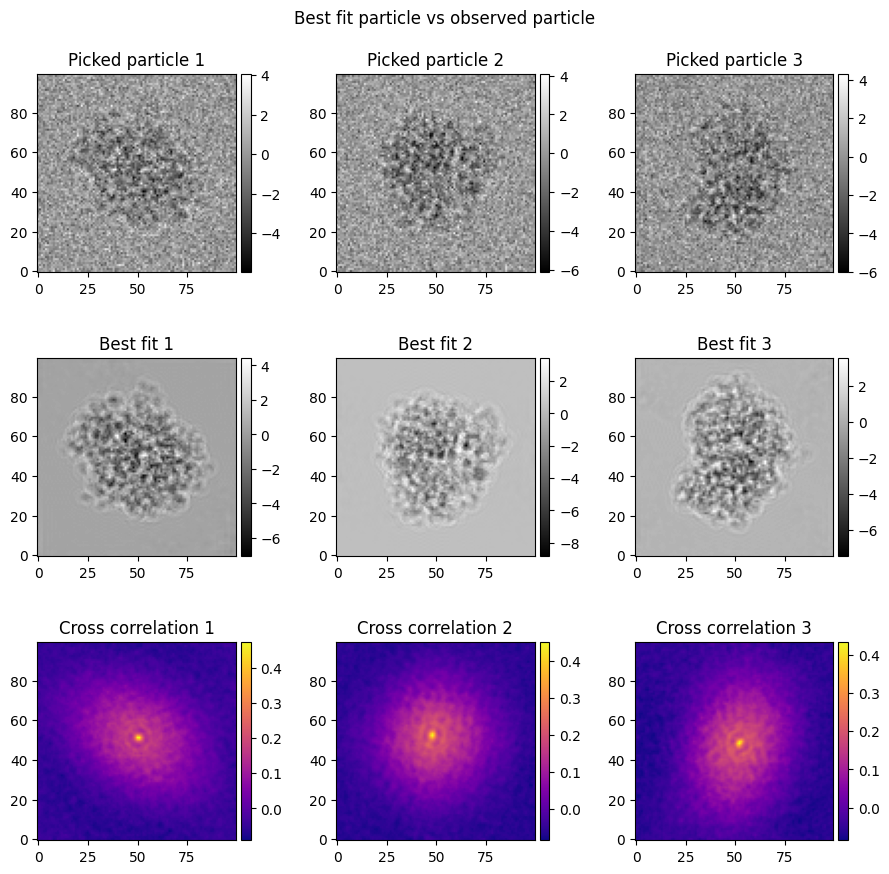

In [15]:
n_images = particle_stack.image_stack.shape[0]
solution_image_stack = simulate_solution_image_stack(solution_pipeline)
solution_cross_correlation = compute_solution_cross_correlation(
    solution_pipeline, fourier_image_stack
)
fig, axes = plt.subplots(figsize=(3 * n_images, 3 * 3), ncols=n_images, nrows=3)
fig.suptitle("Best fit particle vs observed particle")
for i in range(n_images):
    observed = particle_stack.image_stack[i]
    simulated = solution_image_stack[i]
    cc = solution_cross_correlation[i]
    plot_image(observed, fig, axes[0, i], label=f"Picked particle {i+1}")
    plot_image(simulated, fig, axes[1, i], label=f"Best fit {i+1}")
    plot_image(cc, fig, axes[2, i], label=f"Cross correlation {i+1}", cmap="plasma")
plt.tight_layout()